In [1]:
from wordfreq import word_frequency
from src.train_util import get_train_dev_test, sides, levels, side2labels, get_side_level_mean_max_features, sseg2tseg, tseg2sseg
import pandas as pd        
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
import copy


import math

major_train_studies = ['RUC17', 'ENJA15', 'NJ12', 'STC17', 'SG12', 'ENDU20', 'BML12']
major_test_studies = ['BD13', 'DG01', 'BD08', 'ACS08', 'MS13', 'JLG10', 'LWB09', 'CREATIVE']

def get_word_frequency(words, lang):
    mean_fq = np.mean([max(word_frequency(w, lang), 1e-8) for w in words.split('_')])
    return np.log(mean_fq)

def preprocess(df, standardize=True):
    labels = ['TrtS', 'Dur', 'TrtT']
    
    def get_text_id(study, session, segid):
        textid = session.split('_')[1]
        if study in major_train_studies:
            return f'multiLing_{textid}_{segid}'
        else:
            return f'{study}_{textid}_{segid}'
    
    for label in labels:
        new_label = f'log_{label}'
        df[new_label] = [math.log(val) if val >= 20 else np.nan for val in df[label].values]
        if standardize:
            df[new_label] = zscore(df[new_label].values,nan_policy='omit')

    for side in sides:
        df[f'{side}_tokens'] = df[f'{side}_tokens'].astype(str)
        df[f'{side}_freq'] = df[[f'{side}_tokens', f'{side}_lang']].apply(lambda x: get_word_frequency(x[0], x[1]), axis=1)
        
    
    df["lang_pair"] = df[["src_lang", "tgt_lang"]].apply(lambda x: '-'.join(x), axis=1)
    
    
    
    df["src_seq_id"] = df[["study", "session_id", 'src_segid']].apply(lambda x: get_text_id(x[0], x[1], x[2]), axis=1)
    
    df = df.astype({"tgt_token_ids": "str"})
    df["src_seg_len"] = [len(ids.split("+")) for ids in df.src_token_ids]
    df["tgt_seg_len"] = df["tgt_token_ids"].apply(
        lambda ids: len(ids.split("+")) if pd.notnull(ids) else 0)
    df["translator_id"] = df[['study', 'session_id']].apply(
        lambda x: '{}_{}'.format(x[0], x[1].split('_')[0]), axis=1)
    df['y_ent'] = df['y_ent'].fillna(0) # first token entropy always 0 because attention can only be on itself
    
    
    if standardize:
        for ft in ['src_posq', 'tgt_posq', 'xent', 'xmi', 'x2cont', 'cont2x', 'x_ent', 'x2eos', 'tgtseq2x',  'src_surp', 'y2srcseq_ent', 
                   'eos_xatt', 'y2cont', 'y_ent', 'xmi', 'xent', 'tgt_surp', 'src_freq', 'tgt_freq', 'src_surp', 'tgt_surp', 'x2x', 'y2y']:
            df[ft] = zscore(df[ft].values,nan_policy='omit')
    
    return df


def get_data(att_dir, standardize=True):
    tok_seg_file = f'{att_dir}/nllb-features-token-segment.tsv'
    seg_tok_file = f'{att_dir}/nllb-features-segment-token.tsv'
    sent_sent_file = f'{att_dir}/nllb-features-sentence-sentence.tsv'
    tok_seg_df = preprocess(pd.read_csv(tok_seg_file, sep='\t'), standardize=standardize)
    seg_tok_df = preprocess(pd.read_csv(seg_tok_file, sep='\t'), standardize=standardize)
    sent_sent_df = preprocess(pd.read_csv(sent_sent_file, sep='\t'), standardize=standardize)
    
    data = {'src': {'token': tok_seg_df, 'segment': seg_tok_df.drop_duplicates(["study", "session_id", 'src_segid','src_token_ids']), 'sentence': sent_sent_df},
       'tgt': {'token': seg_tok_df, 'segment': tok_seg_df.drop_duplicates(["study", "session_id", 'src_segid','tgt_token_ids']), 'sentence': sent_sent_df}}
    return data

side2labels = {'tgt': ['log_TrtT','log_Dur'], 'src': ['log_TrtS']}
features = {'src': [  'src_surp', 'x2x', 'x2cont', 'x2eos', 'x_ent', 'cont2x', 'tgtseq2x',],
            'tgt': ['tgt_surp', 'xent',  'eos_xatt',  'y2srcseq_ent',  'y2y',  'y2cont', 'y_ent']}

control_features = {
    side: {level: [f'{side}_seg_len',f'{side}_freq', f'{side}_posq'] for level in levels} for side in sides
}

for side in sides:
    control_features[side]['sentence'] = [f'{side}_seg_len',f'{side}_freq']

In [2]:
data = get_data('attention-norm', standardize=False)

Building prefix dict from /Users/limz2/opt/anaconda3/lib/python3.9/site-packages/wordfreq/data/jieba_zh.txt ...
Dumping model to file cache /var/folders/qc/x6n5b8kx7xv7q1g5_fkt1_6h0000gn/T/jieba.u32a0a43e1c3774ef5c2c44e933f01ea8.cache
Loading model cost 0.048 seconds.
Prefix dict has been built successfully.


In [3]:
participants = set()
for side in sides:
    for level in ['token', 'segment']:
        participants = participants.union(set(data[side][level]['translator_id'].unique()))

print(len(participants))

312


In [4]:
from scipy.stats import norm
import math

def likelihood(preds, labels, std):
    return np.mean([norm(pred, std).logpdf(label) for pred, label in zip(preds, labels)])
    

In [5]:
from scipy.stats import pearsonr, spearmanr
from statsmodels.base._penalties import L2
import statsmodels.formula.api as smf
def mixed_model(fixed_features, random_features, groups, df, diff_measure, fe_penalty=False):
    filtered_data = df.dropna(subset=[diff_measure] + fixed_features + random_features)
    
    if len(fixed_features) > 0:
        equation = f"{diff_measure} ~ {' + '.join(fixed_features)}" 
        vcf = {ft: f" 0 + {ft}" for ft in random_features}
        md = smf.mixedlm(equation, filtered_data[fixed_features + random_features + [groups, diff_measure]], groups=groups, vc_formula=vcf,  re_formula=f'1')
        # md = smf.mixedlm(equation, filtered_data[fixed_features + random_features + [groups, diff_measure]], groups=groups)
        if fe_penalty:
            l2_penalty = L2(0.01)
            mdf = md.fit(method=["lbfgs"], fe_pen=l2_penalty)
        else:
            mdf = md.fit(method=["lbfgs"])
        predictions = mdf.predict(filtered_data).values
        return {'md': mdf, 'summary': mdf.summary(), 'prediction': predictions, 'params': mdf.params, 
               'equation': equation, 'resid': filtered_data[diff_measure].values - predictions,
                'pvalues': mdf.pvalues, 'tvalues': mdf.tvalues, 'log-likelihood': mdf.llf, 'resid': mdf.resid, 'random_effects': mdf.random_effects, 
                'pearson': pearsonr(mdf.fittedvalues, filtered_data[diff_measure].values),  
                'spearman': tuple(spearmanr(mdf.fittedvalues, filtered_data[diff_measure].values)), 
                'conf_int': mdf.conf_int()}

In [6]:
rng = np.random.default_rng(seed=44)
random_seqs = rng.permutation(data['src']['token']['src_seq_id'].unique())
trains, tests = [], []
nseqs = len(random_seqs)
kfold = 10
foldsize = nseqs//kfold
for i in range(0, kfold*foldsize, foldsize):
    test_ids = random_seqs[i:i+foldsize]
    train_dt, test_dt = {side: {} for side in sides}, {side: {} for side in sides}
    for side in sides:
        for level in levels:
            df = data[side][level]
            test_dt[side][level] = df[df['src_seq_id'].isin(test_ids)].sample(frac=1, random_state=rng)
            train_dt[side][level] = df[~df['src_seq_id'].isin(test_ids)].sample(frac=1, random_state=rng)
    trains.append(train_dt)
    tests.append(test_dt)

In [7]:
trains[1]['tgt']['token'].head()

,src_lang,tgt_lang,study,session_id,src_tokens,tgt_tokens,src_segid,tgt_segid,src_token_ids,tgt_token_ids,...,log_TrtS,log_Dur,log_TrtT,src_freq,tgt_freq,lang_pair,src_seq_id,src_seg_len,tgt_seg_len,translator_id
17461,en,ja,ENJA15,P23_T1,receives,を,0,0,4+5,15,...,NaN,NaN,5.993961,-11.074671,-3.661264,en-ja,multiLing_T1_0,2,1,ENJA15_P23
51841,en,da,ACS08,P11_T2,what,der,8,8,14,18,...,4.605170,6.859615,5.937536,-6.032287,-4.537512,en-da,ACS08_T2_8,1,1,ACS08_P11
5346,en,zh,RUC17,P11_T3,do,付出,4,4,40,43+44+45,...,7.193686,NaN,7.014814,-6.101279,-10.131644,en-zh,multiLing_T3_4,1,3,RUC17_P11
77144,fr,pl,DG01,P29_T1,bon_semble,podoba,7,7,4+6,12,...,NaN,6.553933,NaN,-7.559761,-8.589764,fr-pl,DG01_T1_7,2,1,DG01_P29
6791,en,zh,RUC17,P05_T4,Some,一些,2,2,1,3+4,...,5.587249,NaN,8.808967,-6.450330,-7.461141,en-zh,multiLing_T4_2,1,2,RUC17_P05


In [8]:
def update_results(all_res, res):
    for side in all_res:
        for level in all_res[side]:
            for label in side2labels[side]:
                for k, v in res[side][level][label].items():
                    all_res[side][level][label][k] = all_res[side][level][label].get(k, [])
                    all_res[side][level][label][k].append(v)
    return all_res

In [9]:
def get_test_llh(res, control_res, test, label):
    md, control_md = res['md'], control_res['md']
    test_lb = test.dropna(subset=[label])
    
    test_control_preds = control_md.predict(test_lb) 
    test_preds = md.predict(test_lb)
    test_labels = test_lb[label].values
    
    control_std = np.std(control_res['resid'])
    std = np.std(res['resid'])
    control_llh = [likelihood([pred], [label], control_std) for pred, label in zip(test_control_preds, test_labels)]
    llh = [likelihood([pred], [label], std) for pred, label in zip(test_preds, test_labels)]
    llh_delta = [x-y for x, y in zip(llh, control_llh)]
    return llh_delta, llh, control_llh

In [14]:
import warnings
warnings.filterwarnings('ignore')

def cross_validate(trains, tests, control_features, features):
    all_results = {side: {level: {label: {} for label in side2labels[side]} for level in levels} for side in sides}
    for train, test in zip(trains, tests):
        results = {side: {level: {} for level in levels} for side in sides}
        for side in sides:
            for level in levels:
                for label in side2labels[side]:
                    gp_result = {}
                    gp_result['control'] = mixed_model(control_features[side][level], ['translator_id'], 'lang_pair', train[side][level], label)
                    for gp in features[side]:
                        currset = f'control+{gp}'
                        gp_result[currset] = mixed_model(control_features[side][level] + [gp], ['translator_id'], 'lang_pair', 
                                                           train[side][level], label)
                        
                        test_llh_delta, test_llh, control_llh = get_test_llh(gp_result[currset], gp_result['control'], test[side][level], label)
                        gp_result[currset]['test_llh_delta'] = test_llh_delta
                        gp_result[currset]['test_llh'] = test_llh
                        gp_result['control']['test_llh'] = control_llh
                        
                    results[side][level][label] = gp_result
        all_results = update_results(all_results, results)
        # print(all_results[side][level][label]['control+y2y'][-1]['test_llh_delta'])
    return all_results

# all_results = cross_validate(trains, tests, control_features, features)

In [15]:
surp_control_features = copy.deepcopy(control_features)
surp_control_features['src'] = {level: surp_control_features['src'][level] + ['src_surp'] for level in levels}
surp_control_features['tgt'] = {level: surp_control_features['tgt'][level] + ['xent'] for level in levels}
att_features = copy.deepcopy(features)
att_features['src'].remove('src_surp')
att_features['tgt'].remove('tgt_surp')
att_features['tgt'].remove('xent')

# surp_control_results = cross_validate(trains, tests, surp_control_features, att_features)

In [2162]:

for side in sides:
    for level in levels:
        for label in side2labels[side]:
            for gp, ress in surp_control_results[side][level][label].items():
                if gp != 'control':
                    for i in range(len(ress)):
                        if 'test_llh_delta_surp' not in surp_control_results[side][level][label][gp][i]:
                            surp_control_results[side][level][label][gp][i]['test_llh_delta_surp'] = surp_control_results[side][level][label][gp][i]['test_llh_delta']
                            surp_control_results[side][level][label][gp][i]['test_llh_delta'] =  [llh-ctrl_llh for llh, ctrl_llh in zip(
                                surp_control_results[side][level][label][gp][i]['test_llh'], all_results[side][level][label]['control'][i]['test_llh'])]
                        


In [13]:
def get_metric_vals(all_results, metric, metric_func=lambda x, met: x.get(met), concat_values=False):
    vals = {side: {} for side in sides}
    
    for side, lvl_lbl_res in all_results.items():
        for level, lbl_res in lvl_lbl_res.items():
            vals[side][level] = {}
            for label, gp_ress in lbl_res.items():
                gps = []
                vls = []
                for gp, ress in gp_ress.items():
                    if metric in ress[0]:
                        for res in ress[:10]:
                            # print(res.keys())
                            if concat_values:
                                for vl in metric_func(res, metric):
                                    gps.append(gp)
                                    vls.append(vl)
                            else:
                                gps.append(gp)
                                vls.append(metric_func(res, metric))
                vals[side][level][label] = pd.DataFrame({'predictor': gps, 'metric': vls})
    return vals

### Saving models/results

In [10]:
## save results
import statsmodels.api as sm
import json, pickle, cloudpickle

# for side in sides:
#     for level in levels:
#         for label in side2labels[side]:
#             for gp, ress in all_results[side][level][label].items():
#                 for i, res in enumerate(ress):
#                     res['md'].save(f'mixed_models/{side}-{level}-{label}-{gp}_{i}.pickle')



# md = sm.load('mixed_models/tgt-segment-log_TrtT-control+y_ent_9.pickle')

# with open('mixed_models/all-results.pkl', 'wb') as f:
#     pickle.dump(all_results, f)

# with open('mixed_models/surp-control-results.pkl', 'wb') as f:
#     pickle.dump(surp_control_results, f)

# with open('mixed_models/lpair-results.pkl', 'wb') as f:
#     pickle.dump(lpair_results, f)
    
# with open('mixed_models/lpair-surp-results.pkl', 'wb') as f:
#     pickle.dump(lpair_surp_results, f)

with open('mixed_models/all-results.pkl', 'rb') as f:
    all_results = pickle.load(f)
    
with open('mixed_models/surp-control-results.pkl', 'rb') as f:
    surp_control_results = pickle.load(f)
    
with open('mixed_models/lpair-results.pkl', 'rb') as f:
    lpair_results = pickle.load(f)
    
with open('mixed_models/lpair-surp-results.pkl', 'rb') as f:
    lpair_surp_results = pickle.load(f)

In [27]:
feature_names = {'y2srcseq_ent': r'$H^\mathrm{c}_{v,x}$', 'eos_xatt': r'$f^\mathrm{c}_{v,\mathrm{eos}}$', 
                 'xent': r'$s_\mathrm{mt}$', 'tgt_surp': r'$s_\mathrm{lm}$', 'y_ent': r'$H^\mathrm{d}_{v, \overleftarrow{v}}$', 'src_surp': r'$s_\mathrm{lm}$', 
                 'x2x': r'$f^\mathrm{e}_{u,u}$', 'x2cont': r'$f^\mathrm{e}_{u,\bar{u}}$', 'x2eos': r'$f^\mathrm{e}_{u,\mathrm{eos}}$', 
                 'y2y': r'$f^\mathrm{d}_{v,v}$', 'y2cont': r'$f^\mathrm{d}_{v,\bar{v}}$', 'cont2x':  r'$f^\mathrm{e}_{\bar{u},u}$',
                 'x_ent': '$H^\mathrm{e}_{u,x}$', 'tgtseq2x': r'$f^\mathrm{c}_{y,u}$',
                'tgt_seg_len': 'length', 'src_seg_len': 'length', 'tgt_posq': 'position', 'src_posq': 'position', 'tgt_freq': 'frequency', 
                'src_freq': 'frequency', }

label_colors = {'src-token-log_TrtS': 'lightcoral','src-segment-log_TrtS': 'tab:red',
         'tgt-token-log_TrtT': 'lightskyblue', 'tgt-segment-log_TrtT': 'tab:blue',
         'tgt-token-log_Dur': 'lightgreen', 'tgt-segment-log_Dur': 'tab:green'}

def label_names(side, level, label, split=False):
    labels = {'log_TrtS': 'reading time', 'log_TrtT': 'reading time', 'log_Dur': 'duration'}
    side_names = {'src': 'source', 'tgt': 'target'}
    level_names = {'token': 'word'}
    if split:
        return f'{side} {level}\n{labels[label]}'
    else:
        return ' '.join([elem for elem in [side_names[side], level_names.get(level, level), labels.get(label, None)] if elem is not None])

### Delta log-likelihood

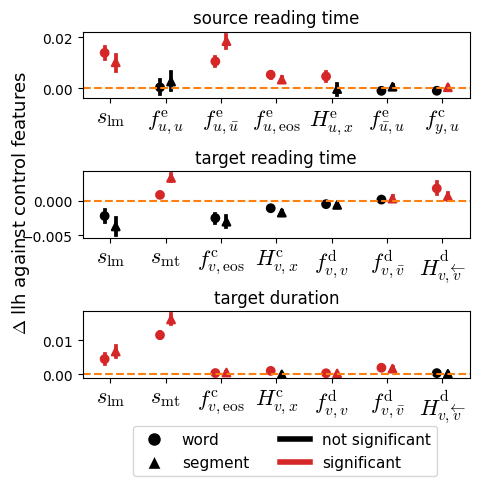

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.lines import Line2D
import matplotlib

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# plt.rc('text', usetex=True)
# plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

params = {'mathtext.fontset': 'cm' }          
plt.rcParams.update(params)

def get_sig_color(sig, sig2=None, thresh=0.05, sig_color='tab:red', sig2_color='blue', non_sig_color='black'):
    if sig2 is not None and (sig < thresh and sig2 < 0.05):
        return sig2_color
    elif sig < thresh:
        return sig_color
    else:
        return non_sig_color


llh_delta = get_metric_vals(all_results, 'test_llh_delta', concat_values=True)
llh_delta_surp_control = get_metric_vals(surp_control_results, 'test_llh_delta', concat_values=True)
llh_delta_surp_surp = get_metric_vals(surp_control_results, 'test_llh_delta_surp', concat_values=True)

fig, axes = plt.subplots(3,1, figsize=(5,4.5), sharey='row',  gridspec_kw={'wspace':0.1, 'hspace':1.1})
row_id = 0
for side in sides:
    for label in side2labels[side]:
        ax = axes[row_id]
        
        dfs = []
        for col_id, level in enumerate(['token', 'segment']):
            df = llh_delta[side][level][label]
            df['feature'] = df['predictor'].apply(lambda x: x.split('+')[-1])
            # df = df[df['feature'].isin(selected_features[side])]
           
            df['level'] = level
            dfs.append(df)
            
        df = pd.concat(dfs)
        df['feature_id'] = df['feature'].apply(lambda x: features[side].index(x))
        df = df.sort_values('feature_id')
        
        
        fts  = [lb.replace('control+', '') for lb in df['predictor'].unique()]
        tok_colors = ['tab:red' if sigfig[side]['token'][label][ft].pvalue < .05 else 'black'  for ft in fts ]
        seg_colors = ['tab:red' if sigfig[side]['segment'][label][ft].pvalue < .05 else 'black' for ft in fts ]
        sns.pointplot(df, x='feature', y='metric', capsize=.0, join=False, hue='level', hue_order=['token', 'segment'],
                      # palette=['tab:red', 'tab:black', 'tab:red', 'tab:black'], 
                      # color='tab:blue',
                      markers=["o", "^"], ax=ax, dodge=0.2, scale=0.8)
        

        for collection, colors in zip(ax.collections, [tok_colors, seg_colors]):
            collection.set_color(colors) 

        colors = []
        for c in tok_colors + seg_colors:
            for _ in range(3):
                colors.append(c)
        for line, color in zip(ax.get_lines(), colors):
            line.set_c(color) 
        ax.legend().remove()

        ax.set_xlabel('')
        ax.set_ylabel('')

        ax.set_xticklabels([feature_names.get(ft, ft) for ft in fts], size=16)
        ax.set_title(label_names(side, None, label), size=12)
        ax.axhline(0, ls='--', color='tab:orange')
        row_id += 1
        
txt = fig.text(-0.02, 0.5, '$\Delta$ llh against control features', va='center', rotation='vertical', size=13)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='word',
                          markerfacecolor='black', markersize=10),
                   Line2D([0], [0], marker='^', color='w', label='segment',
                          markerfacecolor='black', markersize=10),
                    Line2D([0], [0], color='black', lw=4, label='not significant'),
                   Line2D([0], [0], color='tab:red', lw=4, label='significant')]

lgd = fig.legend(handles=legend_elements, bbox_to_anchor=(0.85, 0.02), fontsize=11, ncol=2)

fig.tight_layout() 
plt.savefig('figures/delta-llh.pdf', bbox_extra_artists=(lgd,txt), bbox_inches='tight', dpi=1200)
plt.show()

In [25]:
lpair_surp_results['all'] = surp_control_results
lpair_sigfig_control['all'] = surp_sigfig_control
lpair_sigfig_surp['all'] = surp_sigfig_surp

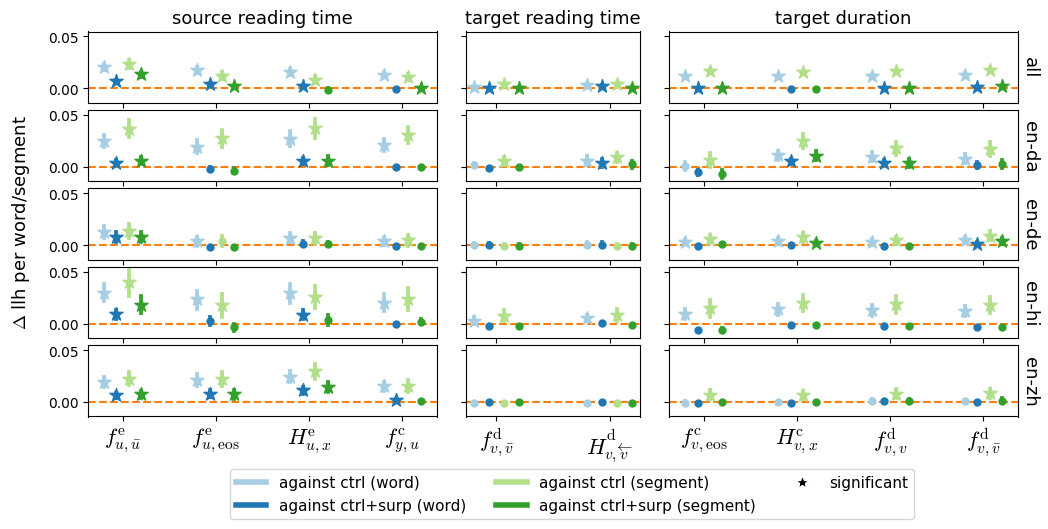

In [59]:

row_max = [0.05, 0.05, 0.03, 0.06, 0.05]
abs_max = .06

fig, axes = plt.subplots(len(lang_pairs) + 1, 3,  figsize=(12, 5), sharey=True, gridspec_kw={'width_ratios': [4,2,4], 'wspace':0.1, 'hspace':0.1})
col_id = 0
for side in sides:
    for label in side2labels[side]:
        for row_id, lpair in enumerate(sorted(lpair_surp_results.keys())):
            res = lpair_surp_results[lpair]
            llh_delta_surp_control = get_metric_vals(res, 'test_llh_delta', concat_values=True)
            llh_delta_surp_surp = get_metric_vals(res, 'test_llh_delta_surp', concat_values=True)
            ax = axes[row_id][col_id]
            surp_dfs, surp_ddfs = [], []
            for level in ['token', 'segment']:
                surp_df = llh_delta_surp_control[side][level][label]
                surp_df['feature'] = surp_df['predictor'].apply(lambda x: x.split('+')[-1])
                surp_df['feature_id'] = surp_df['predictor'].apply(lambda x: features[side].index(x.split('+')[-1]))
                surp_df = surp_df.sort_values('feature_id')
                surp_df = surp_df[surp_df['feature'].isin(att_significant_features[side][label])]
                surp_df['level'] = level
                surp_df['delta'] = '*ctrl'

                surp_ddf = llh_delta_surp_surp[side][level][label]
                surp_ddf['feature_id'] = surp_ddf['predictor'].apply(lambda x: features[side].index(x.split('+')[-1]))
                surp_ddf = surp_ddf.sort_values('feature_id')
                surp_ddf['feature'] = surp_ddf['predictor'].apply(lambda x: x.split('+')[-1])
                surp_ddf = surp_ddf[surp_ddf['feature'].isin(att_significant_features[side][label])]
                surp_ddf['level'] =  f'{level}'
                surp_ddf['delta'] = '*ctrl+surp'
                surp_dfs.append(surp_df)
                surp_ddfs.append(surp_ddf)

            surp_df = pd.concat(surp_dfs + surp_ddfs)

            fts = surp_df['feature'].unique()
            
            sigfigs = [sigs[side][level][label][ft].pvalue  for level in ['token', 'segment'] for sigs in [lpair_sigfig_control[lpair], lpair_sigfig_surp[lpair]]  for ft in fts]
            # markers = ['*' if sf < .05 else '.' for sf in sigfigs]

            points = sns.pointplot(x=surp_df['feature'], y=surp_df['metric'], hue=surp_df[['level', 'delta']].apply(lambda x: ' '.join(x), axis=1), capsize=.0, join=False, 
                          # palette=[get_sig_color(surp_sigfig_control[side][level][label][ft].pvalue) for ft in fts],
                          hue_order=['token *ctrl', 'token *ctrl+surp', 'segment *ctrl', 'segment *ctrl+surp'],
                          palette='Paired',
                          markers = '.',
                          ax=ax, dodge= 0.4)

        
            for collection in ax.collections:
                collection.set_sizes([10])  

            # colors = [line.get_c() for line in ax.get_lines()]
            # print(colors)
            top = abs_max
            

            all_x_values = [path.get_offsets()[i, 0]  for path in ax.collections for i in range(len(path.get_offsets())) ]
            all_y_values = [path.get_offsets()[i, 1]  for path in ax.collections for i in range(len(path.get_offsets()))]
            
            colors =  [color for color in sns.color_palette("Paired")[:4] for ft in fts ]
            
            for x,y,sf,c in zip(all_x_values, all_y_values, sigfigs, colors):
                marker = '*' if sf < .05 else '.'
                ax.scatter(x=[x], y=[y], marker=marker, color=c, s=100, zorder=200)
            ax.get_legend().remove()
            
            if col_id == 2:
                ax.set_ylabel(lpair, rotation=270, labelpad=15, size=13)
                ax.yaxis.set_label_position("right")
            else:
                ax.set_ylabel('')
            
            ax.set_xlabel('')
            
            if row_id == len(lang_pairs):
                ax.set_xticklabels([feature_names.get(ft, ft) for ft in surp_ddf['feature'].unique()], size=16)
            else:
                ax.set_xticklabels([])
            
            
            if row_id == 0:
                ax.set_title(label_names(side, None, label), size=13)

            ax.axhline(0, ls='--', color='tab:orange')
        col_id += 1
        

        
txt = fig.text(0.06, 0.5, '$\Delta$ llh per word/segment', va='center', rotation='vertical', size=13)

legend_elements = [Line2D([0], [0], color=sns.color_palette("Paired")[0], lw=4, label='against ctrl (word)'),
                   Line2D([0], [0], color=sns.color_palette("Paired")[1], lw=4, label='against ctrl+surp (word)'),
                   Line2D([0], [0], color=sns.color_palette("Paired")[2], lw=4, label='against ctrl (segment)'),
                   Line2D([0], [0], color=sns.color_palette("Paired")[3], lw=4, label='against ctrl+surp (segment)'),
                   Line2D([0], [0], marker='*', color='w', label='significant',
                          markerfacecolor='black', markersize=10),
                   
                   ]

lgd = fig.legend(handles=legend_elements, bbox_to_anchor=(0.82, 0.02), fontsize=11, ncol=3, numpoints=1)

fig.tight_layout()
plt.savefig('figures/delta-llh-att.pdf', bbox_extra_artists=(lgd,txt), bbox_inches='tight', dpi=1200)
plt.show()

### Likelihood significance

In [11]:
from scipy.stats import permutation_test

def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)


def get_delta_sigfig(llh, delta_col='test_llh_delta'):
    sigfig = {side: {level: {label: {} for label in side2labels[side]} for level in levels} for side in sides}
    for side in llh:
        for level in llh[side]:
            for label in llh[side][level]:
                if isinstance(llh[side][level][label], pd.DataFrame):
                    df = llh[side][level][label]
                    # control_vals = df[df['predictor'] == 'control']['metric'].values
                    fts = df['predictor'].unique()

                    for ft in fts:
                        ft_vals = [v for vals in df[df['predictor'] == ft]['metric'].values for v in vals]
                        control_vals = np.zeros(len(ft_vals))
                        sigfig[side][level][label][ft.replace('control+', '')] = permutation_test(
                            (ft_vals, control_vals), statistic=statistic, permutation_type='samples', alternative='greater', random_state=rng, n_resamples=1000)
                elif isinstance(llh[side][level][label], dict):
                    fts = llh[side][level][label].keys()
                    for ft in fts:
                        ft_vals = llh[side][level][label][ft][delta_col]
                        control_vals = np.zeros(len(ft_vals))
                        sigfig[side][level][label][ft.replace('control+', '')] = permutation_test(
                            (ft_vals, control_vals), statistic=statistic, permutation_type='samples', alternative='greater', random_state=rng, n_resamples=1000)
    return sigfig

In [16]:
llh = get_metric_vals(all_results, 'test_llh_delta')
sigfig = get_delta_sigfig(llh)


surp_llh = get_metric_vals(surp_control_results, 'test_llh_delta')
surp_sigfig_control = get_delta_sigfig(surp_llh)

surp_llh_surp = get_metric_vals(surp_control_results, 'test_llh_delta_surp')
surp_sigfig_surp = get_delta_sigfig(surp_llh_surp)


In [17]:
att_significant_features = {side: {} for side in sides}
significant_features = {side: {} for side in sides}

for side in sides:
    for label in side2labels[side]:
        token_sig_fts = set([ft for ft, sig in sigfig[side]['token'][label].items() if sig.pvalue < .05])
        seg_sig_fts = set([ft for ft, sig in sigfig[side]['segment'][label].items() if sig.pvalue < .05])
        sig_fts = list(sorted(token_sig_fts.union(seg_sig_fts), key=features[side].index))
    
        significant_features[side][label] = sig_fts
        att_significant_features[side][label] = [sigft for sigft in sig_fts if 'surp' not in sigft and 'xent' not in sigft]

In [18]:
print(significant_features)
print(att_significant_features)

{'src': {'log_TrtS': ['src_surp', 'x2cont', 'x2eos', 'x_ent', 'tgtseq2x']}, 'tgt': {'log_TrtT': ['xent', 'y2cont', 'y_ent'], 'log_Dur': ['tgt_surp', 'xent', 'eos_xatt', 'y2srcseq_ent', 'y2y', 'y2cont']}}
{'src': {'log_TrtS': ['x2cont', 'x2eos', 'x_ent', 'tgtseq2x']}, 'tgt': {'log_TrtT': ['y2cont', 'y_ent'], 'log_Dur': ['eos_xatt', 'y2srcseq_ent', 'y2y', 'y2cont']}}


### Coefficients

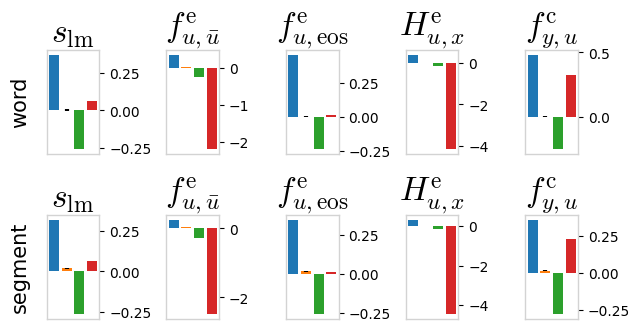

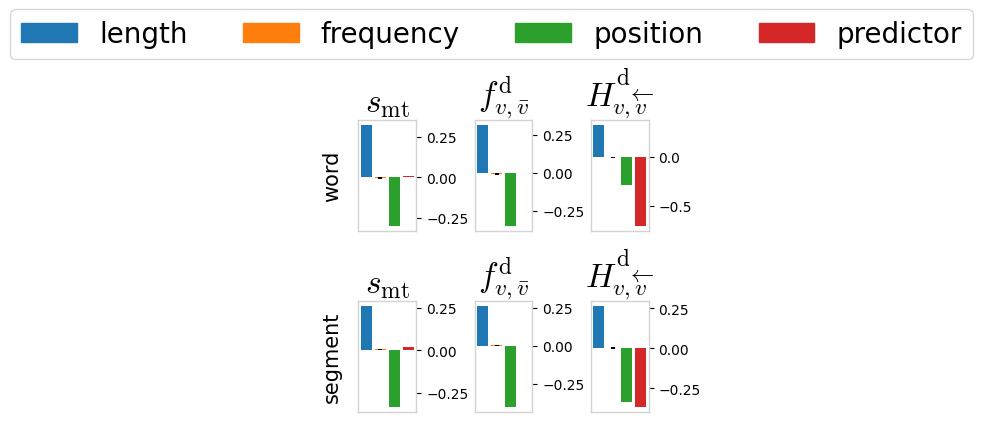

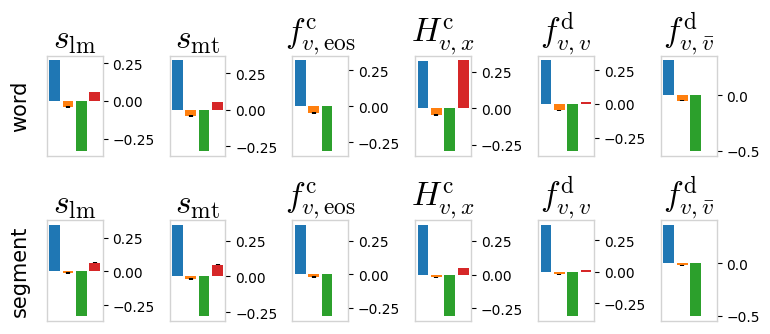

In [2186]:
# fig, axes = plt.subplots(30,1, figsize=(2, 45), sharey=False, sharex=False)

for side in sides:
    for label in side2labels[side]:
        row_size = len(significant_features[side][label])
        row_id = 0
        figsize=(row_size*1.3,10) if label !='log_TrtT' else (row_size*1.3+0.1,11)
        fig, ax = plt.subplots(1, 1, figsize=figsize, gridspec_kw={'wspace':0, 'hspace':0}, sharex=True)

        for level in ['token','segment' ]:
            sig_fts = set([ft for ft, sig in sigfig[side][level][label].items() if sig.pvalue < .05])
            sig_fts = [ft for ft in features[side] if ft in sig_fts]
            
            # row_size = 6
            plt_index = row_id * row_size + 1
            for ft in significant_features[side][label]:
                fts = control_features[side][level] + [ft]
                # fts = fts[::-1]
                ax = plt.subplot(6, row_size, plt_index)
                params = [sample['params'].reset_index().rename(columns={'index': 'feature', 0: 'coef'}) for sample in all_results[side][level][label][f'control+{ft}']]
                df = pd.concat(params)
                df = df[df.feature.isin(fts)]
                # print(df['feature'].unique())
                df['ft_idx'] = df['feature'].apply(lambda x: fts.index(x))
                mean_coef = df.groupby('feature').mean()
                mean_coef = mean_coef.sort_values('ft_idx').coef
                # if ft == 'y2cont':
                #     print(side, level, label, ft, mean_coef)
                ci_coef = df.groupby('feature').std()
                ci_coef *= 1.96
                ci_coef = ci_coef.sort_values('ft_idx').coef / 2 
                # print(ci_coef)
                # print(mean_coef)
                # high, low = max(mean_coef), min(mean_coef)
                # plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
                plt.bar(range(4), mean_coef,  yerr=sem_coef, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'], alpha=1, error_kw={'elinewidth': 3})
                plt.tick_params(axis='both', which='major', labelsize=10)
                plt.xticks([])
                ax.yaxis.tick_right()
                plt.title(feature_names.get(ft, ft), size=24)
                if plt_index == row_id * row_size + 1:
                    plt.ylabel('word' if level=='token' else level, labelpad=12, rotation=90, size=15)
                    # plt.ylabel(label_names(side, level, label, split=True), labelpad=16, rotation=90, size=13)
                # ax.set_title(f'{side} {level} {label} {ft}', size=8)
                plt_index += 1
                # _ = [i.set_linewidth(0.1) for i in ax.spines.values()]
                plt.setp(ax.spines.values(), lw=1, color='lightgrey');
               
            row_id += 1
            
        legend_elements = [Patch(facecolor=color, edgecolor=color, label=ft) 
                           for ft, color in zip(['length', 'frequency', 'position', 'predictor'], ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'])]
        # lgd_pos = (0.9,0.66) if label!='log_TrtT'  else (1.4, 0.85)
        lgd_pos = (1.7,1.05)
        ncol = 4 
        fig.tight_layout()
        # plt.setp(ax.spines.values(), linewidth=0.1)
        
        if label=='log_TrtT':
            lgd = fig.legend(handles=legend_elements, bbox_to_anchor=lgd_pos, fontsize=20, ncol=ncol)
        # lgd = fig.legend(handles=legend_elements, fontsize=14, ncol=4)
        # txt = fig.text(0.5,1.02,'Mixed Model Fixed Effect Coefficient', va='top', ha='center', size=16)
        
            plt.savefig(f'figures/coef_bar_{label}.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=1200, transparent=True)
            
        else:
            plt.savefig(f'figures/coef_bar_{label}.pdf', bbox_inches='tight', dpi=1200)

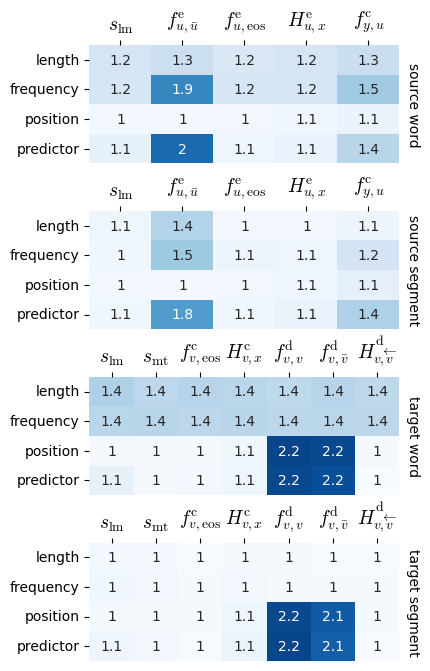

In [63]:
import scipy as sp
def get_vif(df, cols):
    ck = np.column_stack([df[col].values for col in cols])
    cc = sp.corrcoef(ck, rowvar=False)
    VIF = np.linalg.inv(cc)
    return VIF.diagonal().flatten()
    

fig, axes = plt.subplots(4, 1, figsize=(4, 8),gridspec_kw={'wspace':0, 'hspace':0.4})
pid = 0
for rid, side in enumerate(sides):
    for cid, level in enumerate(['token', 'segment']):
        # ax = axes[rid][cid]
        ax = axes[pid]
        df = copy.deepcopy(data[side][level])

        fts =  set([v for vals in significant_features[side].values() for v in vals])
        fts  = [ft for ft in features[side] if ft in fts]
        df = df[control_features[side][level] + fts].dropna()
        corr_mtx = []                           
        for ft in fts:
            corrs = get_vif(df, control_features[side][level] + [ft])
            # print(corrs)
            corr_mtx.append(corrs)
        corr_mtx = np.array(corr_mtx).T
        ft_labels = [feature_names.get(ft, ft) for ft in fts]
        sns.heatmap(corr_mtx, ax=ax, annot=True,  annot_kws={"fontsize":10},  cbar=None, cmap='Blues', vmax=2.3, vmin=1)
        ax.set_ylabel(f"{label_names(side, level, None)}", rotation=270, size=10, labelpad=15)
        ax.yaxis.set_label_position("right", )
        ax.set_yticklabels( ['length', 'frequency', 'position', 'predictor'] , rotation=0) 
        ax.set_xticklabels(ft_labels, rotation=0, size=14) 
        ax.xaxis.tick_top()
        pid+=1
plt.tight_layout()
plt.savefig('figures/vif.pdf', bbox_inches='tight')

### By languages

In [2197]:
all_pair_counts = None

for level in ['token', 'segment']:
    for side in sides:
        for label in side2labels[side]:
            df = data[side][level]
            df = df[df[label].notnull()]
            pair_counts = df[['lang_pair']].value_counts()
            pair_counts[0] = pair_counts[0].astype(int)
            pair_counts = pair_counts.reset_index().rename(columns={0: f'{side}-{level}-{label}'})
            # print(level, side, label)
            # print(pair_counts)
            if all_pair_counts is None:
                all_pair_counts = pair_counts
            else:
                all_pair_counts = all_pair_counts.merge(pair_counts, on='lang_pair', how='outer')

all_pair_counts

,lang_pair,src-token-log_TrtS,tgt-token-log_TrtT,tgt-token-log_Dur,src-segment-log_TrtS,tgt-segment-log_TrtT,tgt-segment-log_Dur
0,en-zh,8949.0,7934.0,3876,6097.0,5922.0,3925
1,en-ja,6806.0,8329.0,2168,4263.0,4299.0,2130
2,en-da,5305.0,5320.0,6176,4121.0,4203.0,4779
3,en-hi,4717.0,4828.0,5205,2917.0,2851.0,2933
4,en-es,4067.0,4020.0,8280,3555.0,3330.0,6072
5,da-en,3844.0,4177.0,5327,3445.0,3493.0,4315
6,en-de,3691.0,3956.0,4534,2991.0,3243.0,3589
7,zh-pt,1210.0,1237.0,1509,1101.0,1027.0,1209
8,pt-zh,1011.0,830.0,203,781.0,755.0,237
9,fr-pl,NaN,NaN,17041,NaN,NaN,13283


In [2200]:
lpairs = all_pair_counts.sort_values('lang_pair')['lang_pair']

In [2203]:
all_pair_counts = all_pair_counts.set_index('lang_pair')

In [2209]:
for lpair in lpairs:
    print(lpair, ' & '.join([str(int(v)) if not np.isnan(v) else str(v) for v in all_pair_counts.loc[lpair].values]))

da-en 3844 & 4177 & 5327 & 3445 & 3493 & 4315
en-da 5305 & 5320 & 6176 & 4121 & 4203 & 4779
en-de 3691 & 3956 & 4534 & 2991 & 3243 & 3589
en-es 4067 & 4020 & 8280 & 3555 & 3330 & 6072
en-hi 4717 & 4828 & 5205 & 2917 & 2851 & 2933
en-ja 6806 & 8329 & 2168 & 4263 & 4299 & 2130
en-nl nan & nan & 7814 & nan & nan & 6318
en-pt nan & nan & 2443 & nan & nan & 2217
en-zh 8949 & 7934 & 3876 & 6097 & 5922 & 3925
fr-pl nan & nan & 17041 & nan & nan & 13283
pt-en nan & nan & 2053 & nan & nan & 1876
pt-zh 1011 & 830 & 203 & 781 & 755 & 237
zh-pt 1210 & 1237 & 1509 & 1101 & 1027 & 1209


In [20]:
count_thresh = 2500

lang_pairs = None
for side in sides:
    for level in ['token', 'segment']:
        for label in side2labels[side]:
            df = data[side][level]
            df = df[df[label].notnull()]
            pair_counts = df['lang_pair'].value_counts()
            exceed_counts = {k for k, val in pair_counts.items() if val > count_thresh}
            if lang_pairs is None:
                lang_pairs = exceed_counts
            else:
                lang_pairs = lang_pairs.intersection(exceed_counts)
            # ax = pair_counts .plot(kind='bar', figsize=(8,5), title=f'{side}-{level}-{label}')
            # ax.bar_label(ax.containers[0])
            # plt.show()

            
            
            
def filter_lpair(lpair, threshold=0):
    for train, test in zip(trains, tests):
        train = train['src']['token']
        test = test['src']['token']
        train = train[train['lang_pair'] == lpair]
        test = test[test['lang_pair'] == lpair]
        for side in sides:
            for level in ['token', 'segment']:
                for label in side2labels[side]:
                    train = train[train[label].notnull()]
                    test = test[test[label].notnull()]
                    if len(train) <= 5*threshold or len(test) <= threshold:
                        return False
    return True

lang_pairs = set(filter(lambda x: filter_lpair(x, threshold=100), lang_pairs))
print(lang_pairs)

{'en-hi', 'en-zh', 'en-de', 'en-da'}


In [2171]:
from sklearn.linear_model import LinearRegression

def linear_regression(train, test, features, label):
    train = train[train[label].notnull()]
    test = test[test[label].notnull()]
    reg = LinearRegression().fit(train[features], train[label].values)
    std = np.std(reg.predict(train[features]) - train[label].values)
    llh = [likelihood([pred], [label], std) for pred, label in zip(reg.predict(test[features]), test[label].values)]
    return {'test_llh': llh, 'params': dict(zip(features, reg.coef_)), 'md': reg}

In [2172]:
def cross_validate_by_langpairs(lang_pairs, trains, tests, control_features, features):
    levels = ['token', 'segment']
    all_results = {lpair: {side: {level: {label: {} for label in side2labels[side]} for level in levels} for side in sides} for lpair in lang_pairs}
    
    for lpair in lang_pairs:
        for train, test in zip(trains, tests):
            results = {side: {level: {} for level in levels} for side in sides}
            for side in sides:
                for level in levels:
                    train0, test0 = train[side][level], test[side][level]
                    train0 = train0[train0['lang_pair'] == lpair]
                    test0 = test0[test0['lang_pair'] == lpair]

                    for label in side2labels[side]:
                        gp_result = {}
                      
                        gp_result['control'] = linear_regression(train0, test0, control_features[side][level], label)
                        for gp in features[side]:
                            currset = f'control+{gp}'
                            gp_result[currset] = linear_regression(train0, test0, control_features[side][level] + [gp], label)
                            gp_result[currset]['test_llh_delta'] = [llh - ctrl_llh for llh, ctrl_llh in zip(gp_result[currset]['test_llh'],gp_result['control']['test_llh'])]

                        results[side][level][label] = gp_result
                        
            all_results[lpair] = update_results(all_results[lpair], results)
    return all_results

# lpair_results = cross_validate_by_langpairs(lang_pairs, trains, tests, control_features, features)

In [2173]:
# lpair_surp_results = cross_validate_by_langpairs(lang_pairs, trains, tests, surp_control_features, att_features)

In [2174]:
# for lpair in lang_pairs:
#     for side in sides:
#         for level in ['token', 'segment']:
#             for label in side2labels[side]:
#                 for gp, ress in lpair_surp_results[lpair][side][level][label].items():
#                     if gp != 'control':
#                         for i in range(len(ress)):
#                             if 'test_llh_delta_surp' not in lpair_surp_results[lpair][side][level][label][gp][i]:
#                                 lpair_surp_results[lpair][side][level][label][gp][i]['test_llh_delta_surp'] = lpair_surp_results[lpair][side][level][label][gp][i]['test_llh_delta']
#                                 lpair_surp_results[lpair][side][level][label][gp][i]['test_llh_delta'] =  [llh-ctrl_llh for llh, ctrl_llh in zip(
#                                     lpair_surp_results[lpair][side][level][label][gp][i]['test_llh'], lpair_results[lpair][side][level][label]['control'][i]['test_llh'])]

In [21]:
lpair_llh_delta, lpair_llh_delta_surp, lpair_llh_delta_control = {}, {}, {}
lpair_sigfig, lpair_sigfig_surp, lpair_sigfig_control = {}, {}, {}
for lpair in lang_pairs:
    lpair_llh_delta[lpair] = get_metric_vals(lpair_results[lpair], 'test_llh_delta')
    lpair_sigfig[lpair] = get_delta_sigfig(lpair_llh_delta[lpair])
    
    lpair_llh_delta_control[lpair] = get_metric_vals(lpair_surp_results[lpair], 'test_llh_delta')
    lpair_sigfig_control[lpair] = get_delta_sigfig(lpair_llh_delta_control[lpair])
    
    lpair_llh_delta_surp[lpair] = get_metric_vals(lpair_surp_results[lpair], 'test_llh_delta_surp')
    lpair_sigfig_surp[lpair] = get_delta_sigfig(lpair_llh_delta_surp[lpair])

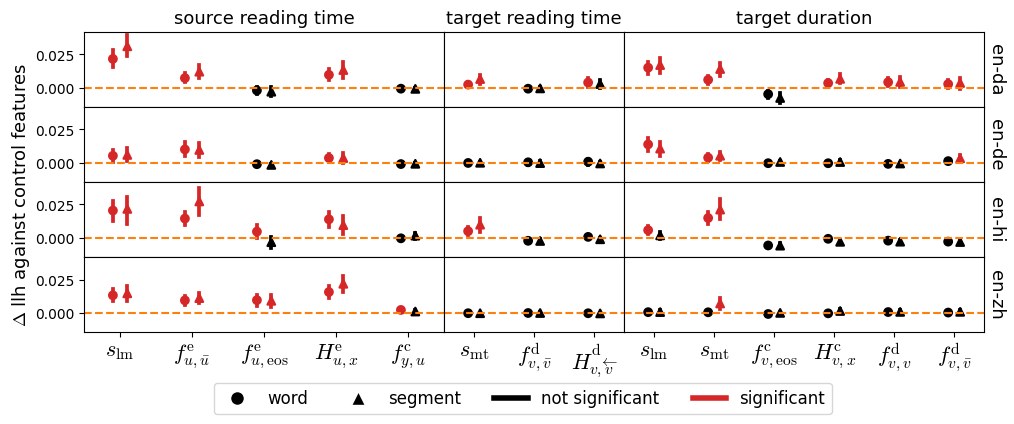

In [31]:
lpair_llh_delta, lpair_llh_delta_surp, lpair_llh_delta_control = {}, {}, {}
for lpair in lang_pairs:
    lpair_llh_delta[lpair] = get_metric_vals(lpair_results[lpair], 'test_llh_delta', concat_values=True) 
    lpair_llh_delta_control[lpair] = get_metric_vals(lpair_surp_results[lpair], 'test_llh_delta', concat_values=True)
    lpair_llh_delta_surp[lpair] = get_metric_vals(lpair_surp_results[lpair], 'test_llh_delta_surp', concat_values=True)


fig, axes = plt.subplots(len(lang_pairs), 3, figsize=(10, 4), sharey=True, sharex='col',constrained_layout=True, gridspec_kw={'width_ratios': [6, 3,  6], 'wspace':0.0, 'hspace':0.0})


for row_id, lpair in enumerate(sorted(lang_pairs)):
    col_id = 0
    for side in sides:
        for label in side2labels[side]:

            # sns.axes_style("whitegrid")
            ax = axes[row_id][col_id]
            # ax.grid()
            df = lpair_llh_delta[lpair][side]['token'][label]
            df['level'] = 'token'
            df['feature'] = df['predictor'].apply(lambda x: x.split('+')[-1])
            df = df[df['feature'].isin(significant_features[side][label])]
            
            df1 = lpair_llh_delta[lpair][side]['segment'][label]
            df1['level'] = 'segment'
            df1['feature'] = df1['predictor'].apply(lambda x: x.split('+')[-1])
            df1 = df1[df1['feature'].isin(significant_features[side][label])]
            df = pd.concat([df, df1])
            # df['sig'] = df[['feature', 'level']].apply(lambda x: lpair_sigfig[lpair][side][x[1]][label][x[0]].pvalue < .05 , axis=1)
            
            
            df['feature_id'] = df['feature'].apply(lambda x: features[side].index(x))
            df = df.sort_values('feature_id')

            fts = att_features[side]

            fts  = [lb.replace('control+', '') for lb in df['predictor'].unique()]
            tok_colors = ['tab:red' if lpair_sigfig[lpair][side]['token'][label][ft].pvalue < .05 else 'black'  for ft in fts ]
            seg_colors = ['tab:red' if lpair_sigfig[lpair][side]['segment'][label][ft].pvalue < .05 else 'black' for ft in fts ]
            sns.pointplot(df, x='feature', y='metric', capsize=.0, join=False, hue='level', hue_order=['token', 'segment'],
                          # palette=['tab:red', 'tab:black', 'tab:red', 'tab:black'], 
                          # color='tab:blue',
                          markers=["o", "^"], ax=ax, dodge=0.2, scale=0.8)
            
            for collection, colors in zip(ax.collections, [tok_colors, seg_colors]):
                collection.set_color(colors) 

            colors = []
            for c in tok_colors + seg_colors:
                for _ in range(3):
                    colors.append(c)
            for line, color in zip(ax.get_lines(), colors):
                # print(line.get_color())
                line.set_c(color) 
            # print(len(ax.get_lines()))
            
            if col_id == 2:
                ax.set_ylabel(lpair, rotation=270, labelpad=15, size=13)
                ax.yaxis.set_label_position("right")
                ax.tick_params(axis='y', which='both',length=0)
            else:
                ax.set_ylabel('')

            if col_id > 0 and col_id < 2:
                ax.get_yaxis().set_visible(False)
                # ax.set_yticklabels([])

            if row_id == len(lang_pairs) -1:
                ax.set_xlabel('')
                ax.set_xticklabels([feature_names.get(ft, ft) for ft in fts], size=16)
            else:
                # ax.set_xlabel('')
                ax.get_xaxis().set_visible(False)
                # ax.xaxis.set_tick_params(labelbottom=False)
                ax.set_xticks([], [])
            ax.legend().remove()

            if row_id == 0:
                ax.set_title(label_names(side, None, label, split=False), size=13)


            ax.axhline(0, ls='--', color='tab:orange')
            col_id += 1

txt = fig.text(-0.01, 0.5, '$\Delta$ llh against control features', va='center', rotation='vertical', size=13)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='word',
                          markerfacecolor='black', markersize=10),
                   Line2D([0], [0], marker='^', color='w', label='segment',
                          markerfacecolor='black', markersize=10),
                    Line2D([0], [0], color='black', lw=4, label='not significant'),
                   Line2D([0], [0], color='tab:red', lw=4, label='significant')]

lgd = fig.legend(handles=legend_elements, bbox_to_anchor=(0.82, 0.05), fontsize=12, ncol=4)

plt.tight_layout()

plt.savefig('figures/delta-llh-lang_pairs.pdf', bbox_extra_artists=(lgd,txt), bbox_inches='tight', dpi=1200)
# fig.suptitle(lpair, fontsize=20)
plt.show()

### Examples

In [41]:
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

data_std = {side: {} for side in sides}
for side in sides:
    for level in ['token', 'segment']:
        df = copy.deepcopy(data[side][level])
        data_std[side][level]  = df


In [44]:
from lxml import etree
penn2uni = {'NP': 'PROPN', 'VV': 'VERB', 'JJ': 'ADJ', 'NN': 'NOUN', 'IN': "ADP", 'PUNC': 'PUNC', 'WD': "DET", 'VH':'AUX', 'DT':"DET", 'TO': 'PART', 'RP':"ADP",
       'CD': "NUM", 'PO':"PART", 'PP':'PRON', 'RB':'ADV', 'CC':'CCONJ', 'VB':'VERB', 'MD': "VERB", 'PD':"DET", 'WP': 'PRON', 'WR': 'ADV', 'SY': "SYM"}

text_token_pos = {}

for textid in range(1, 7):
    tree = etree.parse(f'TPR-DB/multiLing-src/T{textid}.src')
    root = tree.getroot()
    tokens = [child.text for child in root]
    text = [(child.attrib['lemma'], child.attrib['pos'], child.attrib['segId']) for child in root]
    t2_pos = {}
    for token, lem_pos_segid in zip(tokens, text):
        lem, pos, segid = lem_pos_segid
        if pos == 'SENT' or len(pos) == 1:
            pos = 'PUNC'
        elif len(pos) > 2:
            pos = pos[:2]
        # print(pos)
        t2_pos[f'{token}_{segid}'] = penn2uni[pos]
        # t2_pos[f'{token}_{segid}'] = pos
    # t2_pos = {tok: list(sorted(set(tags), key=tags.index)) for tok, tags in t2_pos.items()}
    text_token_pos[textid] = t2_pos
    
sdf = copy.deepcopy(data_std['src']['token'])
multiLing_token = sdf[sdf['study'].isin(major_train_studies)]
multiLing_token['text'] = multiLing_token['session_id'].apply(lambda x: x.split('_')[-1].replace('T', ''))
multiLing_token['POS'] = multiLing_token[['text', 'src_tokens', 'src_segid']].apply(lambda x: text_token_pos[int(x[0][-1])][f'{x[1]}_{int(x[2]+1)}'], axis=1)
# sdf['POS'] = sdf[['text', 'src_tokens', 'src_segid']].apply(lambda x: text_token_pos[int(x[0][-1])][f'{x[1]}_{int(x[2]+1)}'], axis=1)

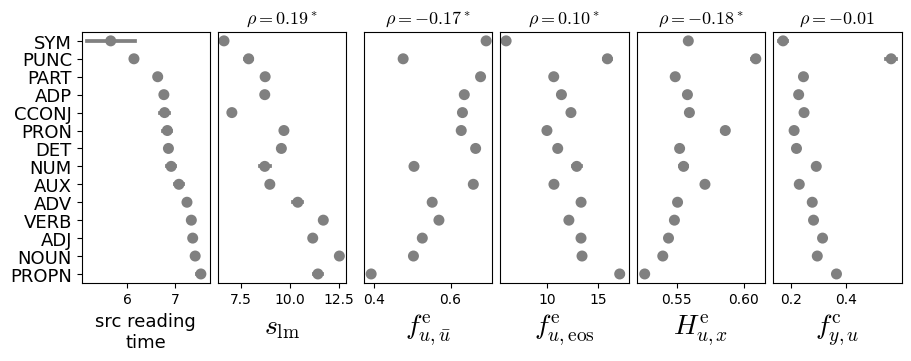

In [47]:

fts = ['log_TrtS'] + significant_features['src']['log_TrtS'] 
fig, axes = plt.subplots(1, len(fts), figsize=(9, 3.5), sharey=True, sharex=False, constrained_layout=True, gridspec_kw={'wspace':0.0})

sdf = copy.deepcopy(multiLing_token)
df = sdf[(sdf['log_TrtS'].notnull())]

tofunc_order = list(df[['POS', 'log_TrtS']].groupby('POS').mean().sort_values('log_TrtS').index)

for i, (ax, ft) in enumerate(zip(axes, fts)):
   
    new_df=pd.DataFrame({'pos': df.POS, ft: df[ft].values})
    new_df['rank'] = new_df['pos'].apply(lambda x: tofunc_order.index(x))
    
    new_df = new_df.sort_values(by='rank')
    
    sns.pointplot(new_df, x=ft, y='pos', ax=ax, capsize=.0, join=False, color=".5", scale = 0.9)
    ax.tick_params(axis='y', which='major', labelsize=13)
    
    if i > 0:
        ax.get_yaxis().set_visible(False)
        ax.set_xlabel(feature_names.get(ft, 'src reading time'), size=20)
        pcorr = pearsonr(df[ft], df.log_TrtS)

        pstr = r'$\rho=$'+ f'${pcorr.statistic:.2f}^*$' if pcorr.pvalue < .001 else r'$\rho=$'+ f'${pcorr.statistic:.2f}$'
        ax.set_title(pstr , size=13)
    else:
        ax.set_ylabel('')
        ax.set_xlabel(feature_names.get(ft, 'src reading\ntime'), size=13)

plt.savefig('figures/src-POS.pdf', bbox_inches='tight', dpi=1200)

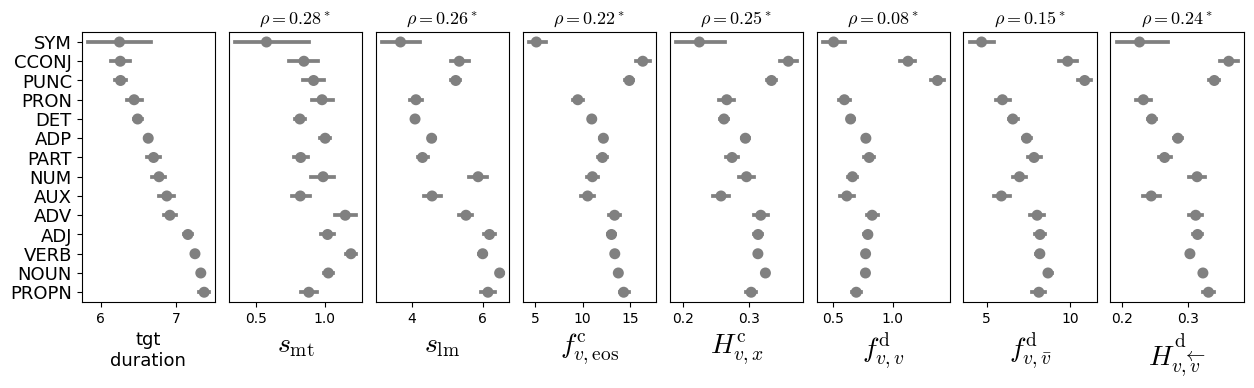

In [46]:
fts = ['log_Dur', 'xent', 'tgt_surp'] + [ft for ft in significant_features['tgt']['log_Dur'] if ft not in ['xent', 'tgt_surp'] ] + ['y_ent']
sdf = copy.deepcopy(multiLing_token)

fig, axes = plt.subplots(1, len(fts), figsize=(15, 3.5), sharex=False, sharey=True, 
                         constrained_layout=True, gridspec_kw={'wspace':0.1})

df = sdf[(sdf['log_Dur'].notnull())]
segment_counts = df[['study', 'session_id', 'tgt_token_ids', 'log_Dur']].groupby(['study', 'session_id', 'tgt_token_ids']).count()
df['log_Dur'] = df[['study', 'session_id', 'tgt_token_ids', 'log_Dur']].apply(lambda x: np.exp(x[3])/segment_counts.loc[x[0], x[1], x[2]].log_Dur, axis=1)
df['log_Dur'] = np.log(df.log_Dur)

for ft in fts:
    if ft!='log_Dur':
        df[ft] = df[['study', 'session_id', 'tgt_token_ids', ft]].apply(lambda x: x[3]/segment_counts.loc[x[0], x[1], x[2]].log_Dur, axis=1)        


tofunc_order = list(df[['POS', 'log_Dur']].groupby('POS').mean().sort_values('log_Dur').index)
for row_id, ft in enumerate(fts):
    ax = axes[row_id]
    df_list = []
    new_df=pd.DataFrame({'pos': df.POS, ft: df[ft].values, 'lang_pair': df.lang_pair})
    new_df['feature'] = ft
    df_list.append(new_df)

    dfs = pd.concat(df_list)

    dfs['rank'] = dfs['pos'].apply(lambda x: tofunc_order.index(x))
    dfs = dfs.sort_values(by=['rank'])
    
    sns.pointplot(dfs, x=ft, y='pos', ax=ax, capsize=.0, join=False, color=".5", scale=0.9)
    ax.tick_params(axis='y', which='major', labelsize=13)
                  
    if row_id >0:
        ax.get_yaxis().set_visible(False)
        ax.set_xlabel(feature_names.get(ft, 'tgt\nduration'), size=20)
        pcorr = pearsonr(df[ft], df.log_Dur)
        pstr = r'$\rho=$'+ f'${pcorr.statistic:.2f}^*$' if pcorr.pvalue < .001 else r'$\rho=$'+ f'${pcorr.statistic:.2f}$'

        ax.set_title(pstr , size=13)     
    else:
        ax.set_ylabel('')
        ax.set_xlabel(feature_names.get(ft, 'tgt\nduration'), size=13)

           
plt.tight_layout()
plt.savefig('figures/tgt-POS.pdf', bbox_inches='tight', dpi=1200)
plt.show()

['RUC17_P02' 'RUC17_P10' 'RUC17_P20' 'RUC17_P04' 'RUC17_P16' 'RUC17_P08'
 'RUC17_P22' 'RUC17_P14' 'RUC17_P03' 'RUC17_P09' 'RUC17_P15' 'ENJA15_P12'
 'ENJA15_P36' 'ENJA15_P24' 'ENJA15_P30' 'ENJA15_P18' 'ENJA15_P06'
 'ENJA15_P27' 'ENJA15_P03' 'ENJA15_P09' 'ENJA15_P33' 'ENJA15_P19'
 'NJ12_P12' 'NJ12_P18' 'NJ12_P06' 'NJ12_P11' 'NJ12_P17' 'NJ12_P19'
 'STC17_P02' 'STC17_P14' 'STC17_P03' 'STC17_P09' 'SG12_P12' 'SG12_P18'
 'SG12_P06' 'SG12_P11' 'SG12_P17' 'SG12_P19' 'SG12_P23' 'BML12_P28'
 'BML12_P16' 'BML12_P06' 'BML12_P03' 'BML12_P25' 'BML12_P17' 'BML12_P21'
 'BML12_P15'] 47 ['en-zh' 'en-ja' 'en-hi' 'en-de' 'en-es']


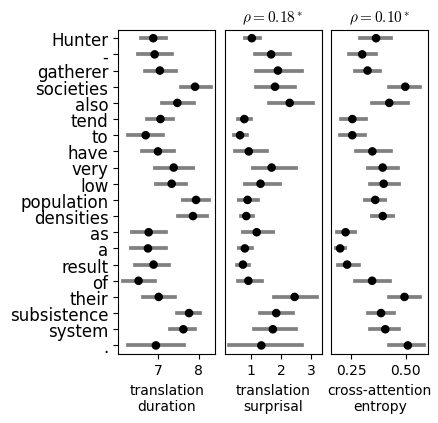

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(4, 4.2), sharey=True, constrained_layout=True, gridspec_kw={'wspace':0.1})
fts = ['log_Dur',  'xent', 'y2srcseq_ent']
ft_name = {'log_Dur': 'translation\nduration', 'xent': 'translation\nsurprisal',  'y2srcseq_ent': 'cross-attention\nentropy', 'eos_xatt': 'cross-attention\nto eos'}
sdf = copy.deepcopy(multiLing_token)

sent = 'multiLing_T6_2'

df = sdf[(sdf['log_Dur'].notnull()) &  (sdf['src_seq_id'] == sent)]


segment_counts = df[['study', 'session_id', 'tgt_token_ids', 'log_Dur']].groupby(['study', 'session_id', 'tgt_token_ids']).count()
df['log_Dur'] = df[['study', 'session_id', 'tgt_token_ids', 'log_Dur']].apply(lambda x: np.exp(x[3])/segment_counts.loc[x[0], x[1], x[2]].log_Dur, axis=1)
df['log_Dur'] = np.log(df.log_Dur)


print(df['translator_id'].unique(), len(df['translator_id'].unique()), df['lang_pair'].unique()) 
for ft in fts:
    if ft!='log_Dur':
        df[ft] = df[['study', 'session_id', 'tgt_token_ids', ft]].apply(lambda x: x[3]/segment_counts.loc[x[0], x[1], x[2]].log_Dur, axis=1)


df['src_mean_id'] = df['src_token_ids'].apply(lambda x: np.mean([int(i) for i in x.split('+')]))
df = df.sort_values(['src_mean_id'])[['src_tokens', 'lang_pair'] + fts]

for i, ft in enumerate(fts):
    ax = axes[i]

    new_df=pd.DataFrame({'src_tokens': df.src_tokens, 'values':df[ft].values})
    
    sns.pointplot(new_df, y='src_tokens', x='values',color='.5',dodge=True, join=False, ax=ax, scale=0.6)
    sns.pointplot(new_df, y='src_tokens', x='values',color='black', ax=ax, errorbar=None, join=False, scale=0.7)
    plt.setp(ax.collections, zorder=100, label="")
    ax.set_ylabel('')
    ax.tick_params(axis='y', which='major', labelsize=12)
    
    if i >0:
        ax.get_yaxis().set_visible(False)
        
        pcorr = pearsonr(df[ft], df.log_Dur)
        pstr = r'$\rho=$'+ f'${pcorr.statistic:.2f}^*$' if pcorr.pvalue < .05 else r'$\rho=$'+ f'${pcorr.statistic:.2f}$'
        ax.set_title(pstr , size=11)  
        
    ax.set_xlabel(ft_name.get(ft), size=10)

plt.tight_layout()
plt.savefig('figures/tgt-example.pdf', bbox_inches='tight', dpi=1200,pad_inches =0.05)